In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import json
import h5py
from utils import img_data_2_mini_batch, imgs2batch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import os
import pickle


%matplotlib inline
%reload_ext autoreload

In [2]:
base_f = 'cocoqa_data_prepro_'
base_n = '5000'
base_fn = base_f + base_n




transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


In [3]:
val_data_h5 = h5py.File(base_fn+'.h5', 'r')

In [4]:

val_data_json = json.load(open(base_fn+'.json', 'r'))
# pad fix
itow = val_data_json['ix_to_word']

wtoi = {iv: ik for ik,iv in itow.items()}
old_pad = wtoi['<pad>']
wtoi['<pad_fix>'] = old_pad
wtoi['<pad>'] = '0'
itow[old_pad] = '<pad_fix>'
itow['0'] = '<pad>'

# print wtoi['<pad>']
# print itow['0']
# print wtoi['<pad_fix>']

assert(wtoi['<pad>'] == '0')
assert(itow['0'] == '<pad>')


# print val_data_json.keys()
# print val_data_h5.keys()

In [5]:
itoa = val_data_json['ix_to_ans']
print(len(itoa))
# print len(itoa)
# print itoa['38']
# print itoa
unique_img_val = val_data_json['unique_img_val']
ques_val = val_data_h5['ques_val'][:]
ans_val = val_data_h5['ans_val'][:]
question_id_val = val_data_h5['question_id_val'][:]
img_pos_val = val_data_h5['img_pos_val'][:]
images = np.array(imgs2batch(unique_img_val, img_pos_val, transform=transform))
ques_val = np.array(ques_val)
ans_val = np.array(ans_val).reshape((-1, 1))

# print images.shape

images = torch.from_numpy(images)
ques_val = torch.from_numpy(ques_val)
ans_val = torch.from_numpy(ans_val)

# print images.size()
# print ques_val.size()
# print ans_val.size()
# print(ans_val.shape)


851


In [6]:
# for i in range(ques_val.size(1)):
#     print ' '.join(filter(lambda kx: kx!='<pad>',(map(lambda wr: itow[str(wr)], ques_val[i].detach().numpy().tolist()))))
#     print ' '.join(map(lambda wr: itoa[str(wr)], ans_val[i].detach().numpy().tolist()))


In [7]:
ques_ans_val = torch.cat((ques_val, ans_val), dim=1)
BATCH_SIZE = 100
split_point = int(0.2 * ques_ans_val.size(0)) # split 20% for testing

ques_ans_splits = torch.split(ques_ans_val, split_point, dim=0)
images_splits = torch.split(images, split_point, dim=0)

ques_ans_test = ques_ans_splits[0]
ques_ans_train = torch.cat(ques_ans_splits[1:], dim=0)

images_test = images_splits[0]
images_train = torch.cat(images_splits[1:], dim=0)

# should be (torch.Size([TRAIN_SIZE, 3, 224, 224]), torch.Size([TRAIN_SIZE, MAX_LENGTH]))
print(images_train.size(), ques_ans_train.size()) 
# should be (torch.Size([TEST_SIZEZ, 3, 224, 224]), torch.Size([TEST_SIZE, MAX_LENGTH]))
print(images_test.size(), ques_ans_test.size())

train_dataset=Data.TensorDataset(images_train, ques_ans_train)
test_dataset=Data.TensorDataset(images_test, ques_ans_test)
train_loader = Data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

test_loader = Data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

torch.Size([4000, 3, 224, 224]) torch.Size([4000, 27])
torch.Size([1000, 3, 224, 224]) torch.Size([1000, 27])


In [8]:
# from naive_lstm import Enc, Dec
# from naive_rnn import Enc, Dec
# from naive_gru import Enc, Dec
from fusion_lstm import Enc, Dec
# from fusion_rnn import Enc, Dec
# from fusion_gru import Enc, Dec

device = torch.device('cuda')
embed_size = 512
hidden_size = 512
ques_vocab_size = len(itow)
ans_vocab_size = len(itoa)+1
num_layers = 1

# print 'embed',embed_size,'hidden',hidden_size,'ques_vocab',ques_vocab_size, 'ans_vocab',ans_vocab_size
encoder = Enc(embed_size).to(device)
decoder = Dec(embed_size, hidden_size, ques_vocab_size, ans_vocab_size, num_layers).cuda()
# encoder.double()


In [9]:
# optimizer and loss
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
lr = 0.01
optimizer = torch.optim.Adam(params,lr=lr)
encoder.train()
decoder.train()
# start your train
lossList = []
accList = []
for epoch in range(1):
    for i, (images, img_ans_val) in enumerate(train_loader):
        ques, ans = torch.split(img_ans_val, 26,dim=1)
        # images of shape [batch, 3, 256, 256]
        # ques of shape [batch, 26]
        # ans of shape [batch, 1]
        
#         print(images.shape)

        lengths = []
        for qix in ques:
            for iy in range(len(qix)):
                if (qix[iy]==0):
                    lengths.append(iy)
                    break;
        tups = []
        for ix in range(ques.size(0)):
            row = ques[ix,:]
            length = lengths[ix]
            image_i = images[ix,:]
            ans_i = ans[ix,:]
            tup = (row, length, image_i, ans_i)
            tups.append(tup)

        sorted_tuples = sorted(tups, key=lambda tup: tup[1], reverse=True)
        questions = torch.stack(list(map(lambda tup: tup[0], sorted_tuples)))
        images = torch.stack(list(map(lambda tup: tup[2], sorted_tuples)))
        answers = torch.stack(list(map(lambda tup: tup[3], sorted_tuples)))
        lengths = list(map(lambda tup: tup[1], sorted_tuples))
        
#         print 'images', images.size()
#         print 'img_ans_val', img_ans_val.size()
#         print 'questions', questions.size()
#         print 'answers', answers.size()
#         print 'lengths', lengths
    
        images = images.to(device)
        questions = questions.to(device).long()
        
        
        features = encoder(images).cuda()
                
#         print '[OUT] features',features.size()
        output = decoder(features, questions, lengths).cuda()
        answers = answers.reshape((-1)).long().cuda()
#         print '[OUT] output ', output.size()
#         print '[OUT] answers ', answers.size()
        loss = F.nll_loss(output, answers)

        # copy here
        lossList.append(loss.item())
        
        _, pred = torch.max(output, dim=1)
        
        correct = pred.eq(answers.long().view_as(pred)).sum()
        acc = float(correct) / float(BATCH_SIZE)
        
        accList.append(acc)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0: 
            print('epoch',epoch,'#', i, 'loss:', loss.item(), 'acc:', acc, 'correct:', correct)
            
        break
        

encoder.eval()
decoder.eval()

print(' ')
print(' TEST ')
print(' ')

lossList_test = []
accList_test = []

for i, (images, img_ans_val) in enumerate(test_loader):
        ques, ans = torch.split(img_ans_val, 26,dim=1)
        # images of shape [batch, 3, 256, 256]
        # ques of shape [batch, 26]
        # ans of shape [batch, 1]

        lengths = []
        for qix in ques:
            for iy in range(len(qix)):
                if (qix[iy]==0):
                    lengths.append(iy)
                    break;
        tups = []
        for ix in range(ques.size(0)):
            row = ques[ix,:]
            length = lengths[ix]
            image_i = images[ix,:]
            ans_i = ans[ix,:]
            tup = (row, length, image_i, ans_i)
            tups.append(tup)

        sorted_tuples = sorted(tups, key=lambda tup: tup[1], reverse=True)
        questions = torch.stack(list(map(lambda tup: tup[0], sorted_tuples)))
        images = torch.stack(list(map(lambda tup: tup[2], sorted_tuples)))
        answers = torch.stack(list(map(lambda tup: tup[3], sorted_tuples)))
        lengths = list(map(lambda tup: tup[1], sorted_tuples))
        
#         print 'images', images.size()
#         print 'img_ans_val', img_ans_val.size()
#         print 'questions', questions.size()
#         print 'answers', answers.size()
#         print 'lengths', lengths
    
        images = images.to(device)
        questions = questions.to(device).long()
        features = encoder(images).cuda()
#         print '[OUT] features',features.size()
        output = decoder(features, questions, lengths).cuda()
        answers = answers.reshape((-1)).long().cuda()
#         print '[OUT] output ', output.size()
#         print '[OUT] answers ', answers.size()
        loss = F.nll_loss(output, answers)

        # copy here
        lossList_test.append(loss.item())
        _, pred = torch.max(output, dim=1)
        
        correct = pred.eq(answers.long().view_as(pred)).sum()
        acc = float(correct) / float(BATCH_SIZE)
        
        accList_test.append(acc)
        
        if i % 5 == 0: 
            print('epoch',epoch,'#', i, 'loss:', loss.item(), 'acc:', acc, 'correct:', correct)

torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
epoch 0 # 0 loss: 6.812115669250488 acc: 0.0 correct: tensor(0, device='cuda:0')
 
 TEST 
 
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
epoch 0 # 0 loss: 4.267160415649414 acc: 0.24 correct: tensor(24, device='cuda:0')
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
epoch 0 # 5 loss: 4.739400863647461 acc: 0.16 correct: tensor(16, device='cuda:0')
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 1024])
torch.Size([100, 512])
torch.Size([100, 51

result/fusion_gru_0.01_512_512.pkl


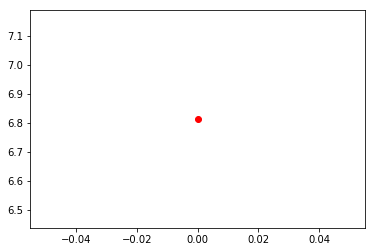

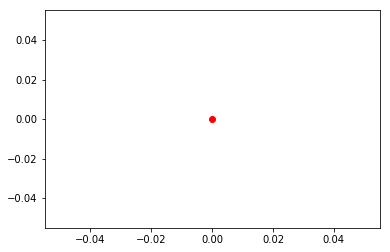

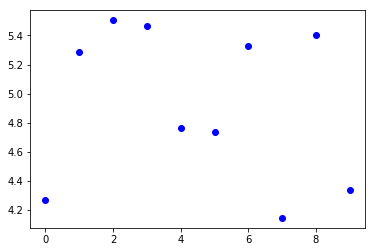

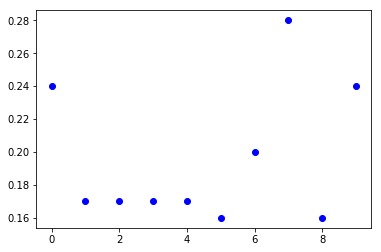

In [10]:
model_type = 'fusion_gru'
train_param = str(lr) + '_' + str(embed_size) + '_' + str(hidden_size)
fname = model_type + '_' + train_param
f_path = 'result/' + fname + '.pkl'

print(f_path)

with open(f_path, 'wb') as f:
    pickle.dump([lossList, accList, lossList_test, accList_test], f, protocol=pickle.HIGHEST_PROTOCOL)



plt.figure()
plt.plot(range(len(lossList)), lossList, 'ro')
plt.show()

plt.figure()
plt.plot(range(len(accList)), accList, 'ro')
plt.show()


plt.figure()
plt.plot(range(len(lossList_test)), lossList_test, 'bo')
plt.show()

plt.figure()
plt.plot(range(len(accList_test)), accList_test, 'bo')
plt.show()